A simple analysis of Covid-19 infection cases. I made a few graphs, 
which help me to understand the situation. I plotted overall confirmed,
active (confirmed - recovered - deaths) and death cases in the world. 
Then I focused my attention to the specific countries.

The script below downloads the latest data.

In [3]:
%%bash
~/Scripts/covid19Git.sh

A    csse_covid_19_time_series/.gitignore
A    csse_covid_19_time_series/README.md
A    csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
A    csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
A    csse_covid_19_time_series/time_series_covid19_deaths_US.csv
A    csse_covid_19_time_series/time_series_covid19_deaths_global.csv
A    csse_covid_19_time_series/time_series_covid19_recovered_global.csv
Checked out revision 3499.


In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

Functions:

In [3]:
def df_from_csv(path):
    test_df = pd.read_csv(path, nrows=1)
    columns = test_df.columns.tolist()
    cols_to_use = [x for x in columns if x not in ['Province/State', 'Lat', 'Long']]
    df = pd.read_csv(path, usecols=cols_to_use)
    df.rename(mapper={'Country/Region': 'Country'}, axis=1, inplace=True)
    return df

In [4]:
# save a daframe as an image
def save_df_as_png(data, name_png):
    ax = plt.subplot(111, frame_on=False) 
    ax.xaxis.set_visible(False)  
    ax.yaxis.set_visible(False)  

    table(ax, data, loc='center')  

    plt.savefig('Output/{}'.format(name_png), bbox_inches='tight')

In [5]:
# Making a function which draws a plot
def draw_countries_plot(nr_subplot, nr_plot_in_subplot, nr_window_days,
              data, countries, title_subplot, name_plot):
    '''
    nr_subplot: int, number of subplots
    nr_plot_in_subplot: nested array-like  
    data: dataframe
    countries: nested array-like
    title_subplot: array-like, if nr_subplot > 1 nested 
    '''
    # set number of xticks, to make it easy to plot all available days, 
    # I have made a condition
    if nr_window_days == 'beg' or nr_window_days == 'beginning':
        window_days = conf_df.columns
    else:
        window_days = conf_df.columns[np.arange(-nr_window_days, 0, 1)]
    
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize=(13, nr_subplot * 10))

    for s in range(nr_subplot):
        ax = fig.add_subplot(nr_subplot, 1, s+1)
        ax.set_title(title_subplot[s], fontsize=20)
        ax.set_xlabel('Day', fontsize=13)

        ax.tick_params(axis='x', labelrotation=90)
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

        # check if you need to split data by checking if there is multiindex
        if isinstance(data.index, pd.core.index.MultiIndex):
            plot_data = data.xs(s)
        else:
            plot_data = data            
        # before plotting let's sort the countries from the most to the least numerous cases
        countries_to_plot = data.loc[countries[s]].sort_values(data.columns[-1], ascending=False).index
        for i in range(nr_plot_in_subplot[s]):
            ax.plot(plot_data[window_days].columns, plot_data[window_days].loc[countries_to_plot[i]],
                      marker='o', linewidth=2.5, label=countries_to_plot[i])

        ax.legend(loc=2)
        ax.grid(axis='y')
    
    fig.savefig('Output/{}'.format(name_plot))
    plt.show()

Code:

In [6]:
# load data
conf_path = '~/IT/Data/Covid19/Input/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
death_path = '~/IT/Data/Covid19/Input/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recov_path = '~/IT/Data/Covid19/Input/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

conf0_df = df_from_csv(conf_path)
death0_df = df_from_csv(death_path)
recov0_df = df_from_csv(recov_path)

# delete the last column of the dataframe
#col_to_drop = conf0_df.columns[-1]
#for d in [conf0_df, death0_df]:
#    d.drop(labels=col_to_drop, axis=1, inplace=True)

# a groupby table, which sums up the values against the countries
conf_df = conf0_df.copy().groupby(by='Country').sum()
death_df = death0_df.copy().groupby(by='Country').sum()
recov_df = recov0_df.copy().groupby(by='Country').sum()

# make a table of active cases
active_df = conf_df - death_df.reindex(conf_df.index) - recov_df.reindex(conf_df.index)

# creating a dataframe with population
pop_path = '~/IT/Data/Covid19/Input/populationByCountry.csv'
pop_df = pd.read_csv(pop_path, usecols=['Country Name', '2018'],
                    index_col='Country Name')

# change the name of the columns and the indices above all to enable a concatenation
pop_df.rename({'2018': 'population18'}, axis=1, inplace=True)
pop_df.rename({'Iran, Islamic Rep.': 'Iran', 'United States': 'US',
              'Korea, Rep.': 'Korea, South', 'Czech Republic': 'Czechia',
              'Russian Federation': 'Russia', 'Egypt, Arab Rep.': 'Egypt',
              'Slovak Republic': 'Slovakia', 'Venezuela, RB': 'Venezuela',
              'Kyrgyz Republic': 'Kyrgyzstan', 'Syrian Arab Republic': 'Syria'},
             axis=0, inplace=True)

pop_conf_df = pd.concat([pop_df, conf_df], axis=1, sort=False)

# drop the rows with nan values
drop_ind = pop_conf_df[(pop_conf_df['1/22/20'].isnull()) | (pop_conf_df['population18'].isnull())].index
pop_conf_df.drop(drop_ind, axis=0, inplace=True)

# make a table of confirmed cases per 10 000 people
conf_per_data = []
for i in range(len(pop_conf_df.index)):
    conf_per_data.append((pop_conf_df.drop(['population18'], axis=1).iloc[i].div(pop_conf_df['population18'].iloc[i])*10000).to_numpy())
    
conf_per_df = pd.DataFrame(data=conf_per_data, columns=conf_df.columns, index=pop_conf_df.index)

# make a table of death cases per 1 000 000 people
rem_ind = [x for x in death_df.index if x not in conf_per_df.index]
death_per0_df = death_df.drop(rem_ind, axis=0).reindex(conf_per_df.index)

death_per_data = []
for i in range(len(death_per0_df.index)):
    death_per_data.append((death_per0_df.iloc[i].div(pop_conf_df['population18'].iloc[i])*10 ** 6).to_numpy())
    
death_per_df = pd.DataFrame(data=death_per_data, columns=death_df.columns, index=death_per0_df.index).sort_values(
conf_df.columns[-1], ascending=False)

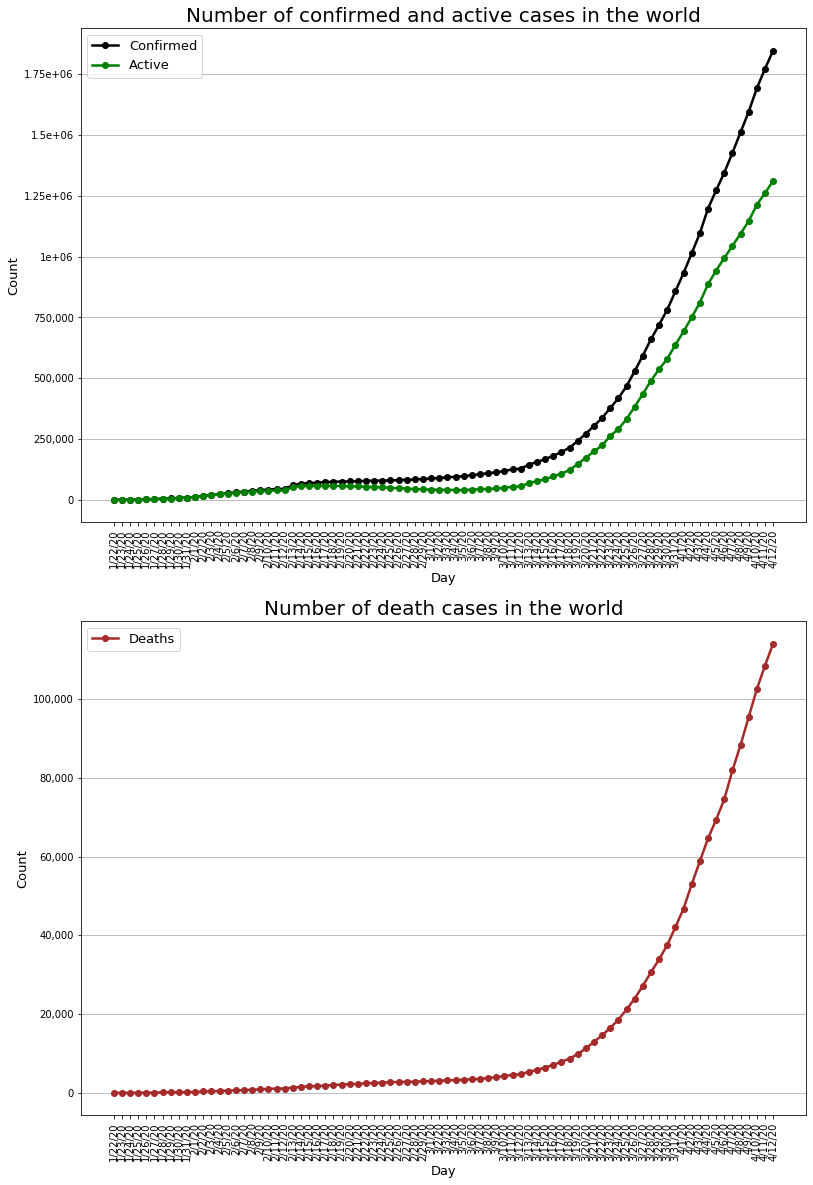

In [7]:
# making a graph of confirmed, active and death cases
conf_global = conf_df.sum()
death_global = death_df.sum()
recov_global = recov_df.sum()
active_global = active_df.sum()

# setting a plot figure
fig, ax = plt.subplots(2, figsize=(13, 20))

# set a first plot
ax[0].set_xlabel('Day', fontsize=13)
ax[0].set_ylabel('Count', fontsize=13)
ax[0].set_title('Number of confirmed and active cases in the world', fontsize=20)

ax[0].plot(conf_global.index.to_numpy(), conf_global.to_numpy(), 
         marker='o', color='black', linewidth=2.5, label='Confirmed')
ax[0].plot(active_global.index.to_numpy(), active_global.to_numpy(),
        marker='o', color='green', linewidth=2.5, label='Active')

ax[0].yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
ax[0].tick_params('x', labelrotation=90)

# set a second plot
ax[1].set_xlabel('Day', fontsize=13)
ax[1].set_ylabel('Count', fontsize=13)
ax[1].set_title('Number of death cases in the world', fontsize=20)

ax[1].plot(death_global.index, death_global.to_numpy(), 
       marker='o', color='brown', linewidth=2.5, label='Deaths')

ax[1].yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
ax[1].tick_params('x', labelrotation=90)

ax[0].legend(loc=0, fontsize=13)
ax[1].legend(loc=0, fontsize=13)
ax[0].grid(axis='y')
ax[1].grid(axis='y')

fig.savefig('Output/1_world_conf_death.png')
plt.show()

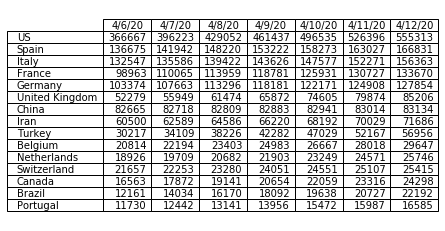

In [8]:
# show the confirmed cases of the most severly affected countries - top 15 countries
conf_df.sort_values(by=conf_df.columns[-1], ascending=False, inplace=True)
# save a table
save_df_as_png(conf_df.iloc[:15, -7:], '2t_conf.png')

conf_df.iloc[:15, -7:].style.format('{:,}')

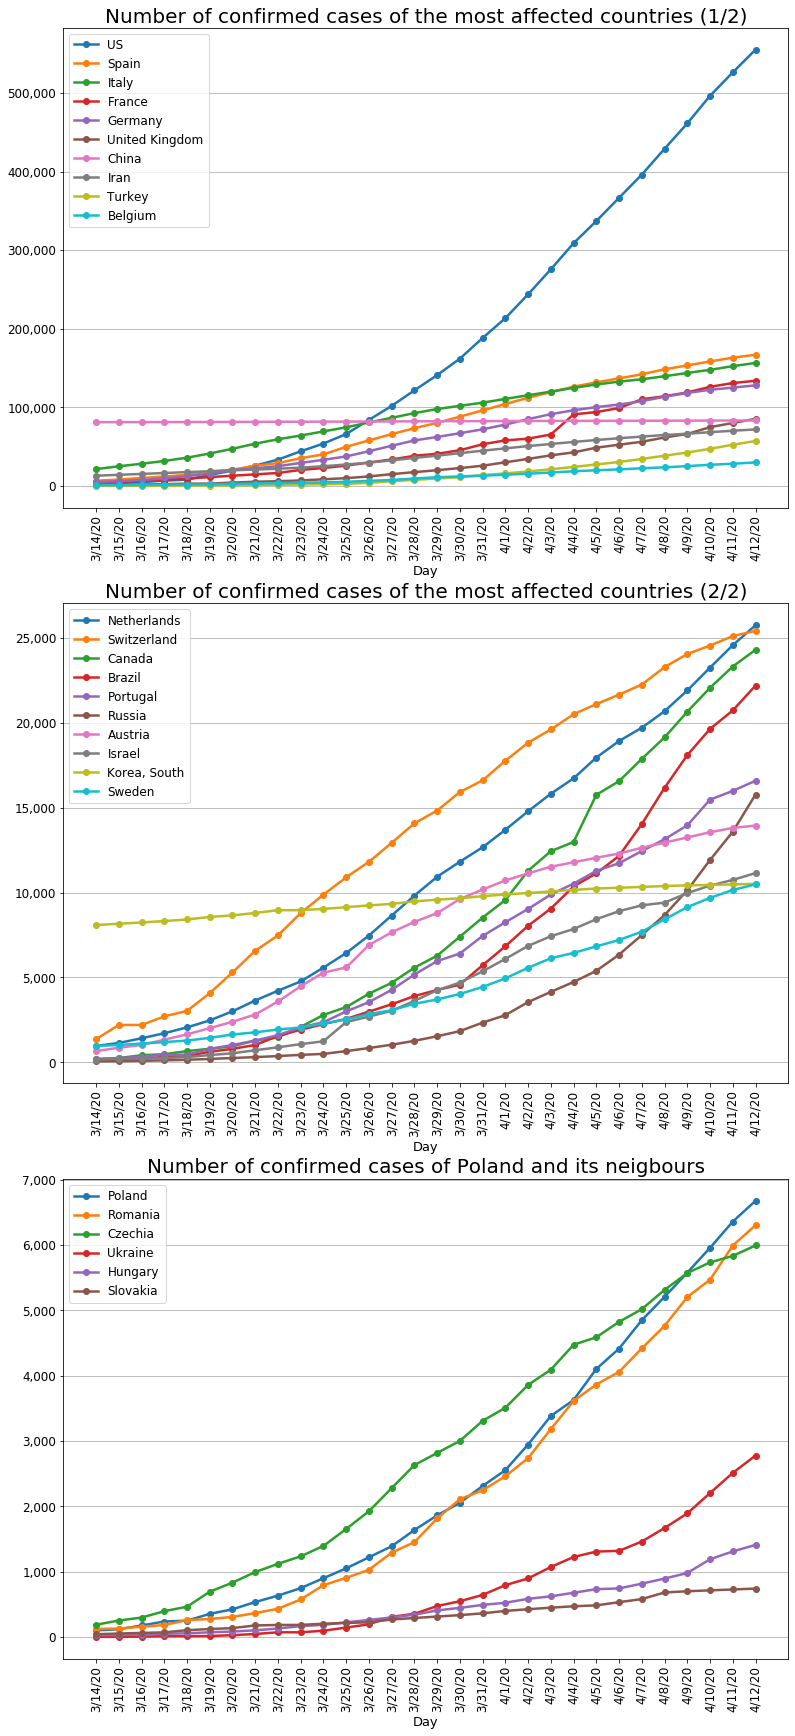

In [9]:
# make a visualisation of confirmed and death cases per capita, two subplots
nr_countries = [10, 10, 6]
nr_window_days = 30
countries = [conf_df.index[np.arange(nr_countries[0])],  
            conf_df.index[np.arange(nr_countries[0], nr_countries[1]+10)],
            ['Poland', 'Czechia', 'Slovakia', 'Hungary', 'Romania', 'Ukraine']]

titles = ['Number of confirmed cases of the most affected countries (1/2)',
         'Number of confirmed cases of the most affected countries (2/2)',
         'Number of confirmed cases of Poland and its neigbours']

draw_countries_plot(len(countries), nr_countries, nr_window_days,
                    conf_df, countries, 
                    titles, '2_conf.png')

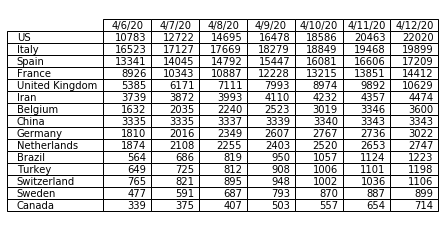

In [10]:
# show the death cases from the last seven days - top 15 countries
death_df.sort_values(by=conf_df.columns[-1], ascending=False, inplace=True)
# save a table
save_df_as_png(death_df.iloc[:15, -7:], '3t_death.png')

death_df.iloc[:15, -7:].style.format('{:,}')

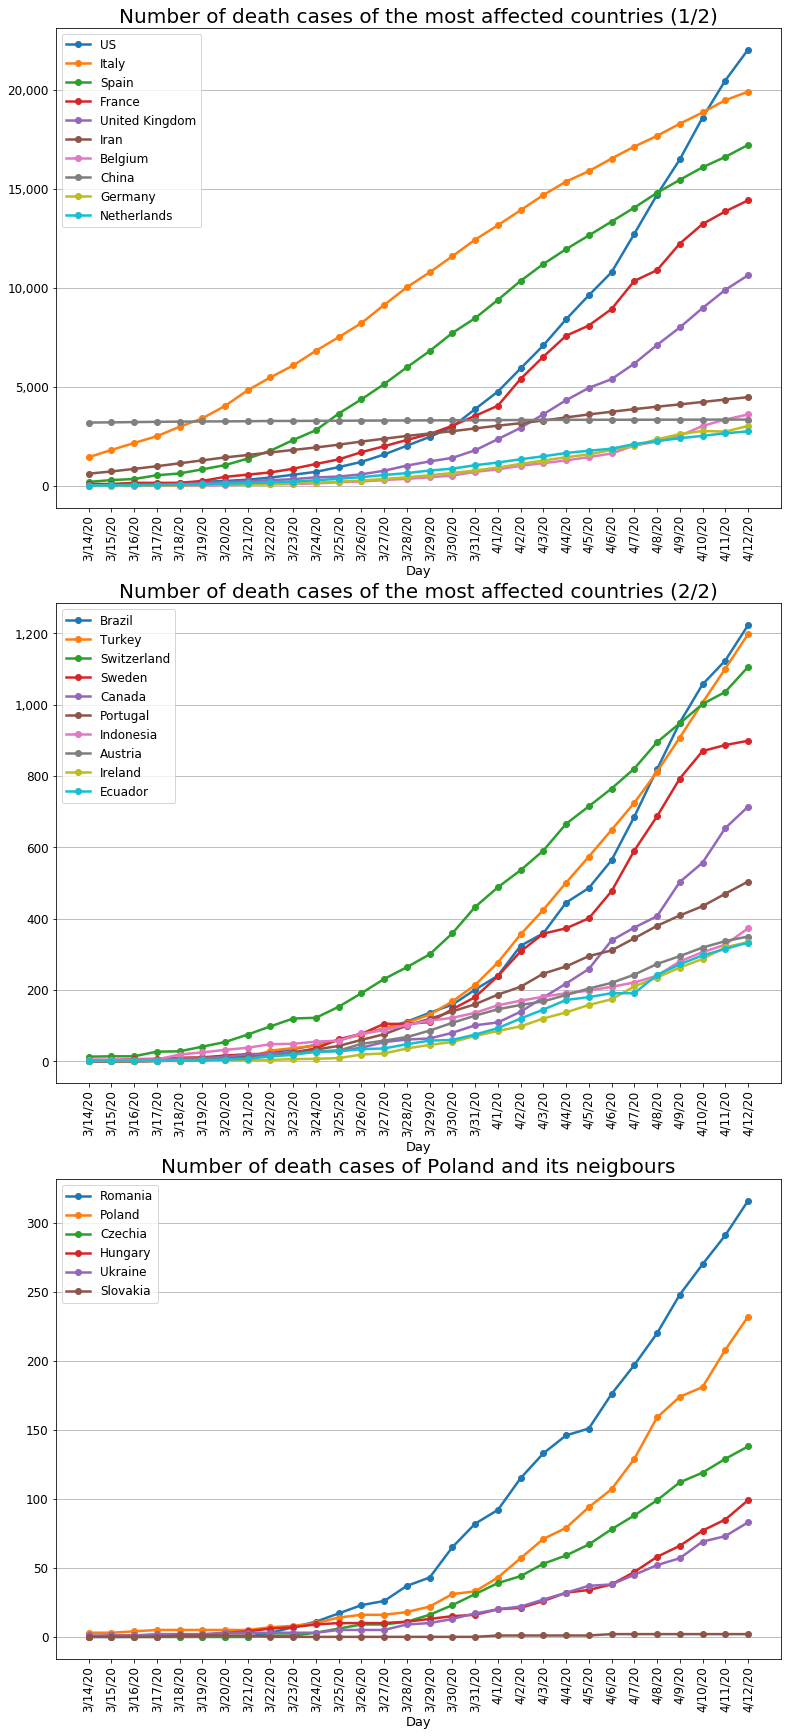

In [11]:
# make a visualisation of confirmed and death cases per capita, two subplots
nr_countries = [10, 10, 6]
nr_window_days = 30
countries = [death_df.index[:nr_countries[0]],
            death_df.index[nr_countries[0]: nr_countries[1]+10],
            ['Poland', 'Czechia', 'Slovakia', 'Hungary', 'Romania', 'Ukraine']]

titles = ['Number of death cases of the most affected countries (1/2)',
         'Number of death cases of the most affected countries (2/2)',
         'Number of death cases of Poland and its neigbours']

draw_countries_plot(len(countries), nr_countries, nr_window_days,
                    death_df, countries, 
                    titles, '3_death.png')

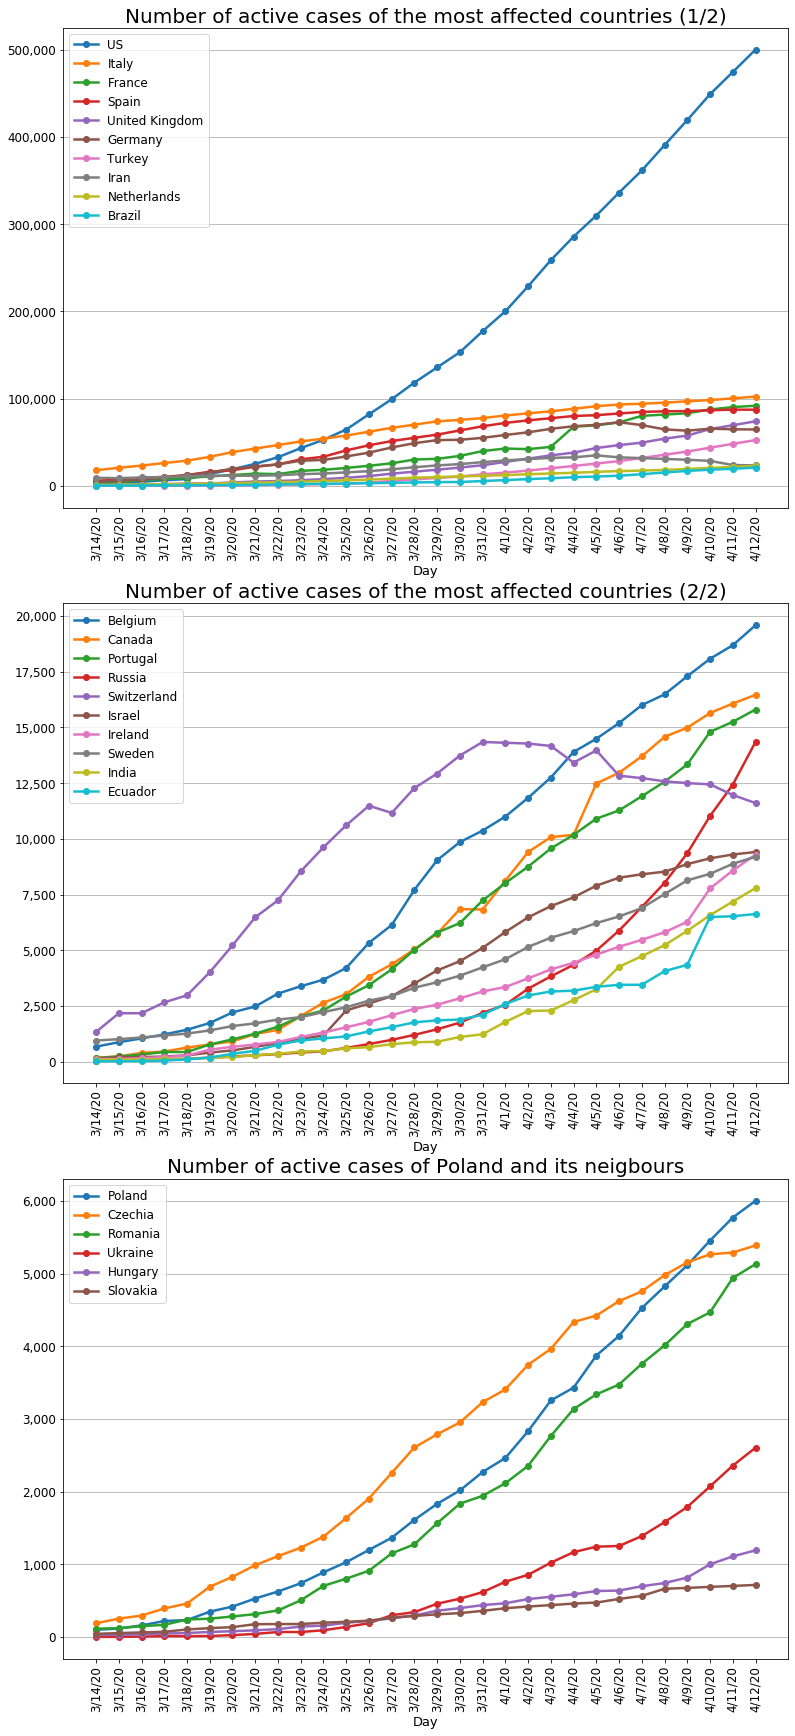

In [12]:
active_df.sort_values(active_df.columns[-1], ascending=False, inplace=True)
# make a visualisation of confirmed and active cases per capita, two subplots
nr_countries = [10, 10, 6]
nr_window_days = 30
countries = [active_df.index[:nr_countries[0]],
            active_df.index[nr_countries[0]: nr_countries[1]+10],
            ['Poland', 'Czechia', 'Slovakia', 'Hungary', 'Romania', 'Ukraine']]

titles = ['Number of active cases of the most affected countries (1/2)',
         'Number of active cases of the most affected countries (2/2)',
         'Number of active cases of Poland and its neigbours']

draw_countries_plot(len(countries), nr_countries, nr_window_days,
                    active_df, countries, 
                    titles, '4_active.png')

In [13]:
# daily increases of confirmed cases in absolute terms
diff_conf_df = conf_df.diff(axis=1).sort_values(conf_df.columns[-1], ascending=False)
# diff_conf_df.sort_values(diff_conf_df.columns[-1], ascending=False, inplace=True)

# daily increases of confirmed cases in percentage
diff_conf_pct_df = ((diff_conf_df / conf_df) * 100).sort_values(conf_df.columns[-1], ascending=False)

# daily increases of deaths in absolute terms
diff_death_df = death_df.diff(axis=1).sort_values(conf_df.columns[-1], ascending=False)

# daily increases of deaths in percentage
diff_death_pct_df = ((diff_death_df / conf_df) * 100).sort_values(conf_df.columns[-1], ascending=False)

# daily increases of active cases
diff_active_df = active_df.diff(axis=1).sort_values(conf_df.columns[-1], ascending=False)

4/6/20   4/7/20   4/8/20   4/9/20  4/10/20  4/11/20  4/12/20
Country                                                                      
US              29595.0  29556.0  32829.0  32385.0  35098.0  29861.0  28917.0
United Kingdom   3843.0   3670.0   5525.0   4398.0   8733.0   5269.0   5332.0
Turkey           3148.0   3892.0   4117.0   4056.0   4747.0   5138.0   4789.0
Italy            3599.0   3039.0   3836.0   4204.0   3951.0   4694.0   4092.0
Spain            5029.0   5267.0   6278.0   5002.0   5051.0   4754.0   3804.0
Germany          3251.0   4289.0   5633.0   4885.0   3990.0   2737.0   2946.0
France           5190.0  11102.0   3894.0   4822.0   7150.0   4796.0   2943.0
Russia            954.0   1154.0   1175.0   1459.0   1786.0   1667.0   2186.0
Iran             2274.0   2089.0   1997.0   1634.0   1972.0   1837.0   1657.0
Belgium          1123.0   1380.0   1209.0   1580.0   1684.0   1351.0   1629.0
Brazil           1031.0   1873.0   2136.0   1922.0   1546.0   1089.0   1465.0
Netherlands       973.0    783.0    973.0   1221.0   1346.0   1322.0   1175.0
Canada            807.0   1309.0   1269.0   1513.0   1405.0   1257.0    982.0
India            1190.0    533.0    605.0    809.0    873.0    848.0    759.0
Japan             515.0    252.0    351.0    410.0    863.0    475.0    743.0

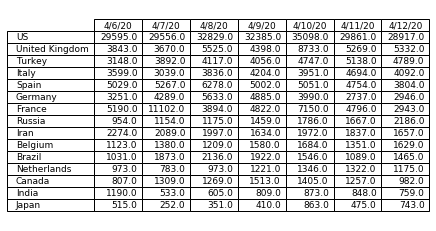

In [14]:
# show a table with daily increases of confirmed cases in absolute terms 
# and save it
show_diff_conf_df = diff_conf_df.loc[diff_conf_df.index[:15], conf_df.columns[-7:]].sort_values(conf_df.columns[-1], ascending=False)
save_df_as_png(show_diff_conf_df, '5t_diff_conf.png')
show_diff_conf_df

4/6/20  4/7/20  4/8/20  4/9/20  4/10/20  4/11/20  4/12/20
Country                                                                  
US              1164.0  1939.0  1973.0  1783.0   2108.0   1877.0   1557.0
United Kingdom   442.0   786.0   940.0   882.0    981.0    918.0    737.0
Spain            700.0   704.0   747.0   655.0    634.0    525.0    603.0
France           833.0  1417.0   544.0  1341.0    987.0    636.0    561.0
Italy            636.0   604.0   542.0   610.0    570.0    619.0    431.0
Germany          226.0   206.0   333.0   258.0    160.0    -31.0    286.0
Belgium          185.0   403.0   205.0   283.0    496.0    327.0    254.0
Iran             136.0   133.0   121.0   117.0    122.0    125.0    117.0
Brazil            78.0   122.0   133.0   131.0    107.0     67.0     99.0
Turkey            75.0    76.0    87.0    96.0     98.0     95.0     97.0
Netherlands      103.0   234.0   147.0   148.0    117.0    133.0     94.0
Switzerland       50.0    56.0    74.0    53.0     54.0     34.0     70.0
Canada            80.0    36.0    32.0    96.0     54.0     97.0     60.0
Portugal          16.0    34.0    35.0    29.0     26.0     35.0     34.0
China              2.0     0.0     2.0     2.0      1.0      3.0      0.0

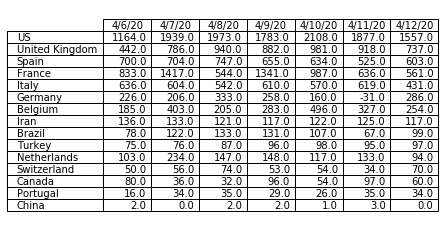

In [15]:
# show a table with daily increases of deaths cases in absolute terms 
# and save it
show_diff_death_df = diff_death_df.loc[conf_df.index[:15], conf_df.columns[-7:]].sort_values(conf_df.columns[-1], ascending=False)
save_df_as_png(show_diff_death_df, '6t_diff_death.png')
show_diff_death_df

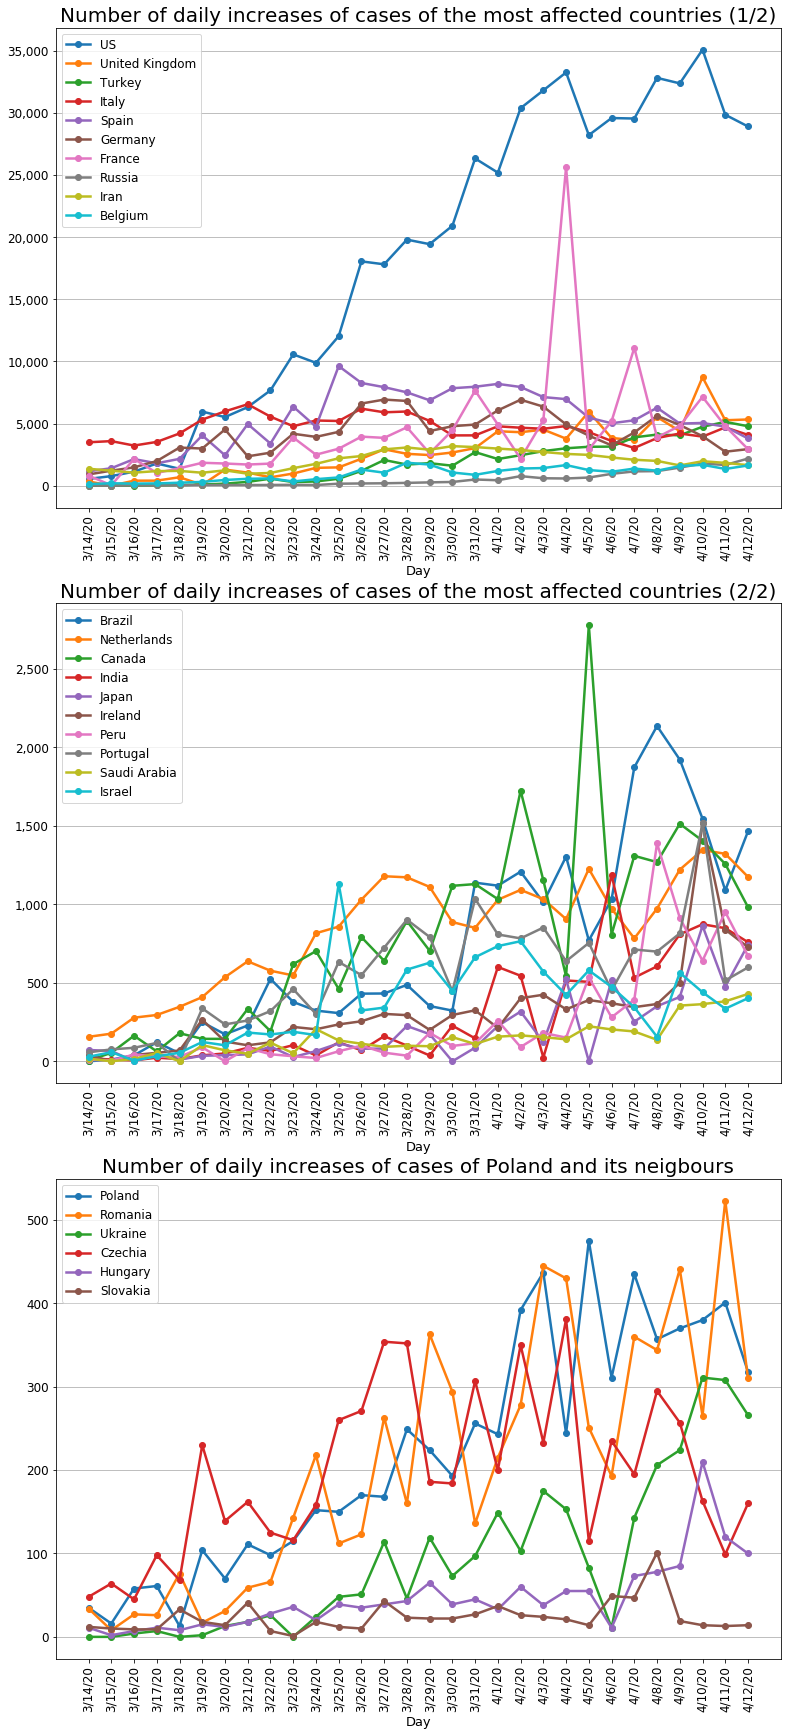

In [16]:
# make a visualisation of daily increases of confirmed cases 
# for 20 most affected countries and Poland and its neigbours
nr_countries = [10, 10, 6]
nr_window_days = 30
countries = [diff_conf_df.index[np.arange(nr_countries[0])],  
            diff_conf_df.index[np.arange(nr_countries[0], nr_countries[1]+10)],
            ['Poland', 'Czechia', 'Slovakia', 'Hungary', 'Romania', 'Ukraine']]

titles = ['Number of daily increases of cases of the most affected countries (1/2)',
         'Number of daily increases of cases of the most affected countries (2/2)',
         'Number of daily increases of cases of Poland and its neigbours']

draw_countries_plot(len(countries), nr_countries, nr_window_days,
                    diff_conf_df, countries, titles, '5a_daily_increases_conf.png')

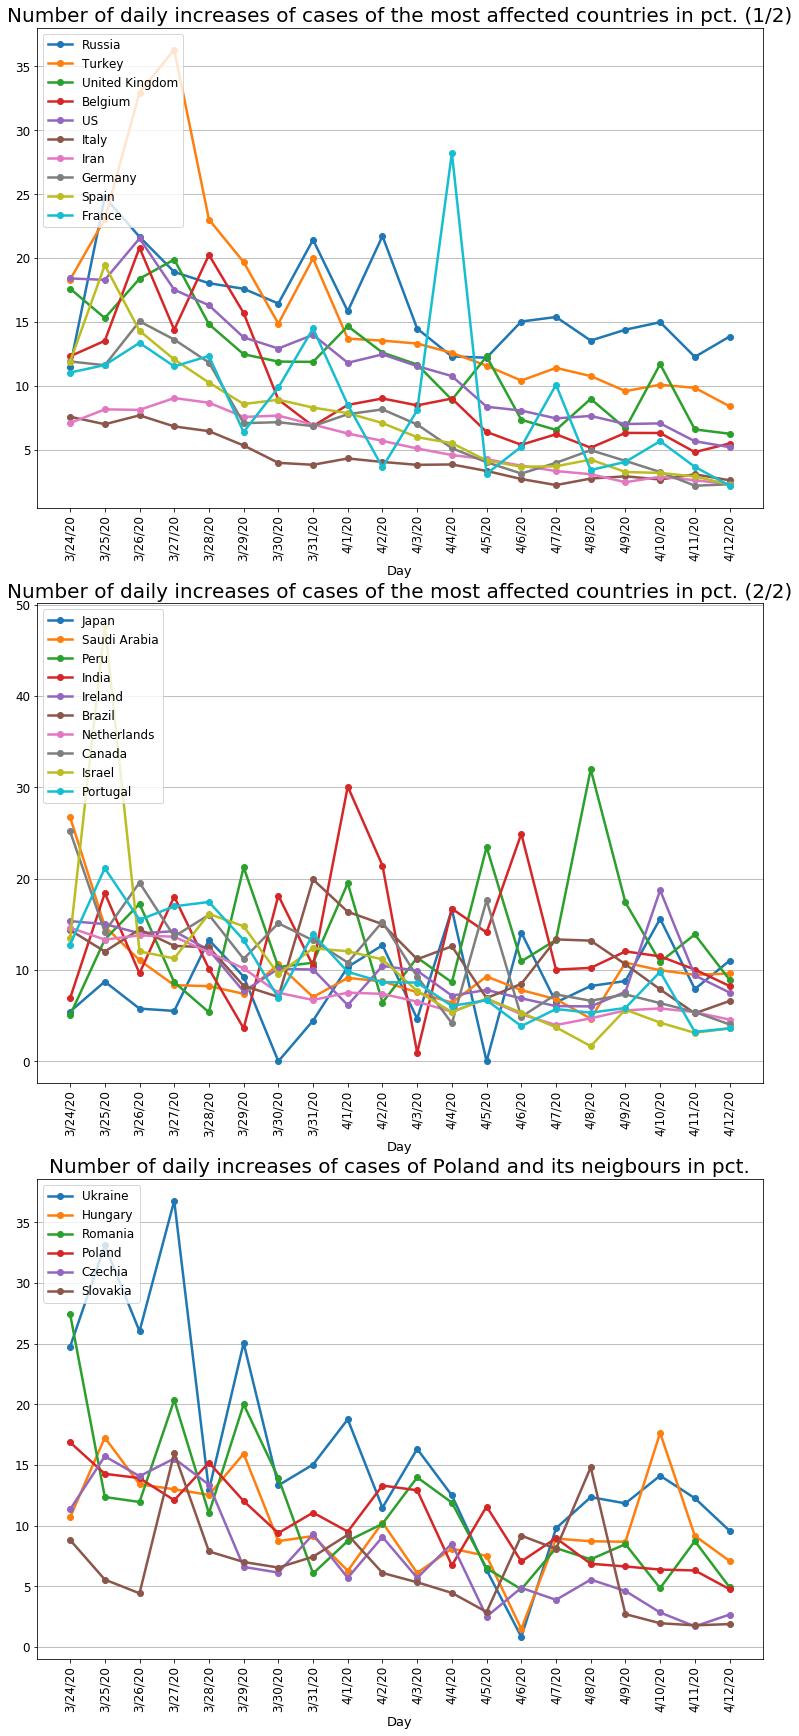

In [17]:
# 2make a visualisation of daily increases of confirmed cases in percentage
# for 20 most affected countries and Poland and its neigbours
nr_countries = [10, 10, 6]
nr_window_days = 20
countries = [diff_conf_df.index[:nr_countries[0]],  
            diff_conf_df.index[nr_countries[0]: nr_countries[1]+10],
            ['Poland', 'Czechia', 'Slovakia', 'Hungary', 'Romania', 'Ukraine']]

titles = ['Number of daily increases of cases of the most affected countries in pct. (1/2)',
         'Number of daily increases of cases of the most affected countries in pct. (2/2)',
         'Number of daily increases of cases of Poland and its neigbours in pct.']

draw_countries_plot(len(countries), nr_countries, nr_window_days,
                    diff_conf_pct_df, countries, titles, '5b_daily_increases_conf_pct.png')

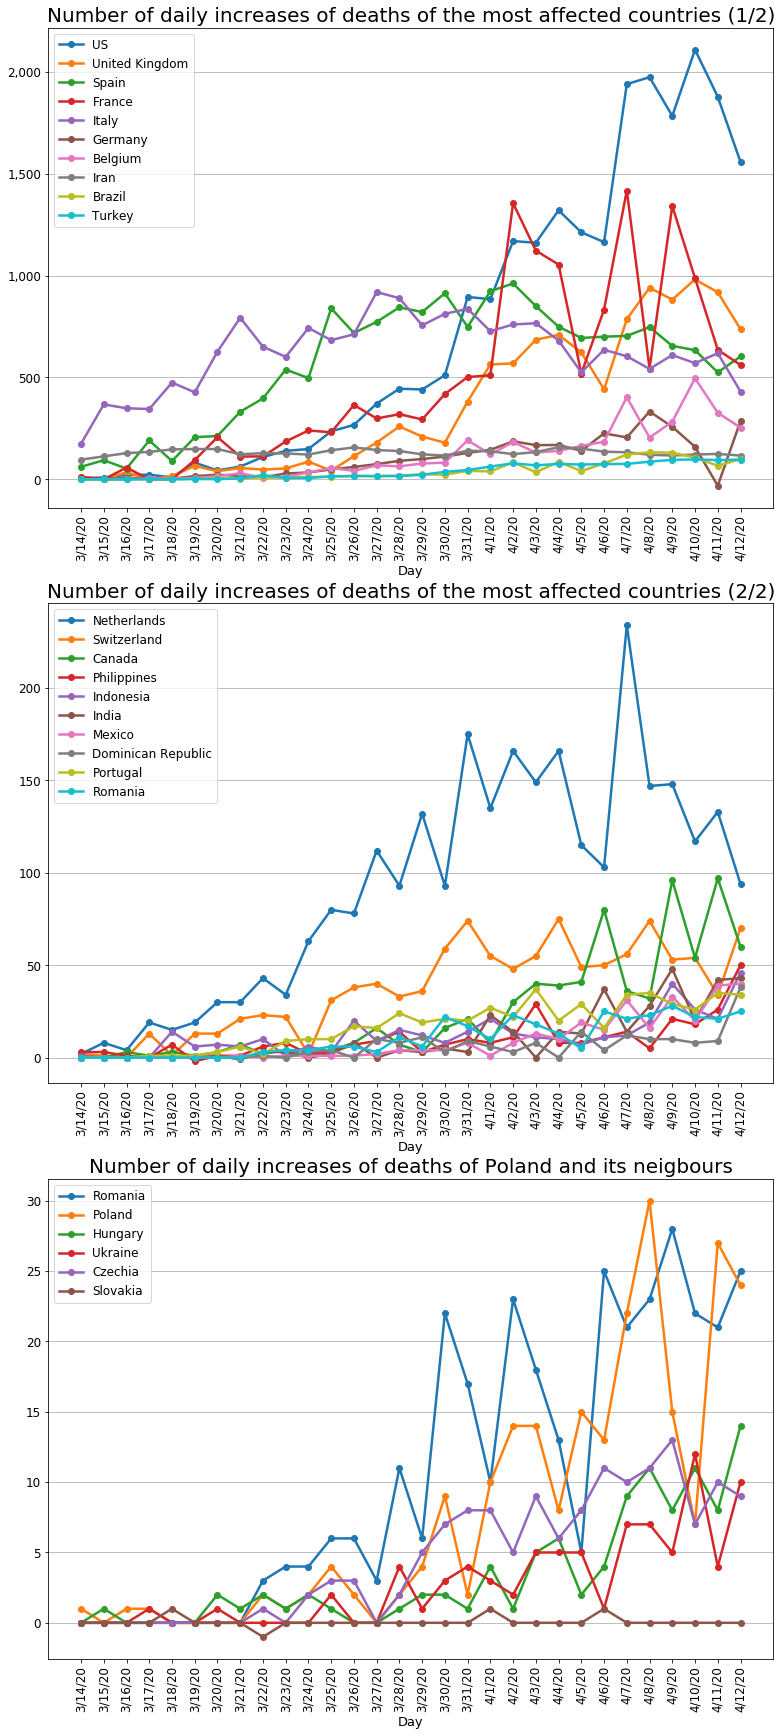

In [18]:
# 3make a visualisation of daily increases
# for 20 most affected countries and Poland and its neigbours
nr_countries = [10, 10, 6]
nr_window_days = 30
countries = [diff_death_df.index[:nr_countries[0]],  
            diff_death_df.index[nr_countries[0]: nr_countries[1]+10],
            ['Poland', 'Czechia', 'Slovakia', 'Hungary', 'Romania', 'Ukraine']]

titles = ['Number of daily increases of deaths of the most affected countries (1/2)',
         'Number of daily increases of deaths of the most affected countries (2/2)',
         'Number of daily increases of deaths of Poland and its neigbours']

draw_countries_plot(len(countries), nr_countries, nr_window_days,
                    diff_death_df, countries, titles, '6a_daily_increases_deaths.png')

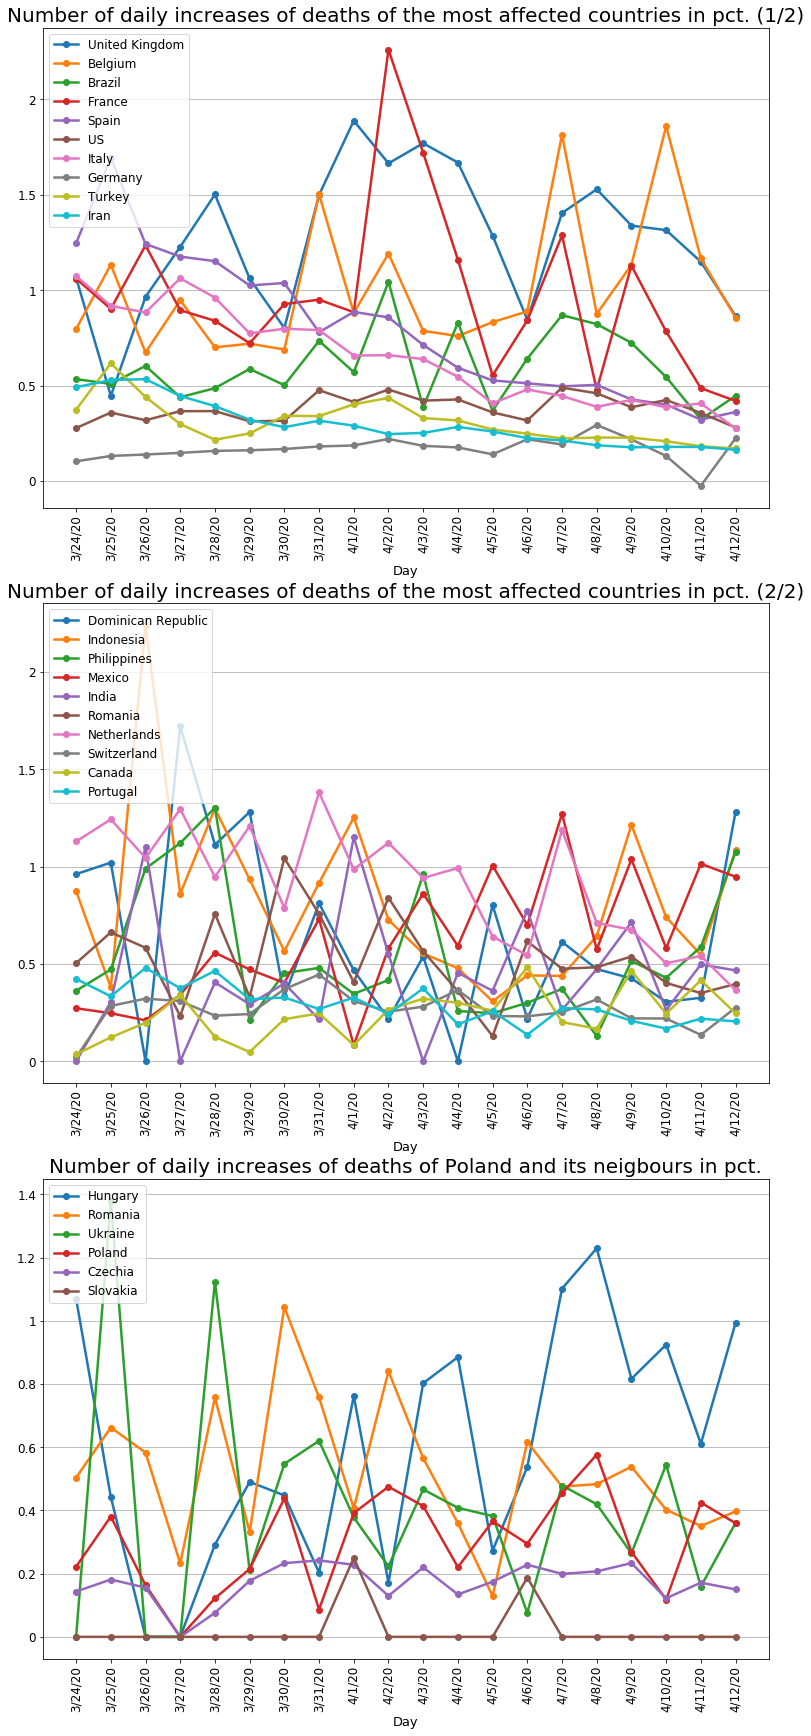

In [27]:
# make a visualisation of daily increases of deaths in percentage 
# for 20 most affected countries and Poland and its neigbours
nr_countries = [10, 10, 6]
nr_window_days = 20
countries = [diff_death_df.index[:nr_countries[0]],  
            diff_death_df.index[nr_countries[0]: nr_countries[1]+10],
            ['Poland', 'Czechia', 'Slovakia', 'Hungary', 'Romania', 'Ukraine']]

titles = ['Number of daily increases of deaths of the most affected countries in pct. (1/2)',
         'Number of daily increases of deaths of the most affected countries in pct. (2/2)',
         'Number of daily increases of deaths of Poland and its neigbours in pct.']

draw_countries_plot(len(countries), nr_countries, nr_window_days,
                    diff_death_pct_df, countries, titles, '6b_daily_increases_death_pct.png')

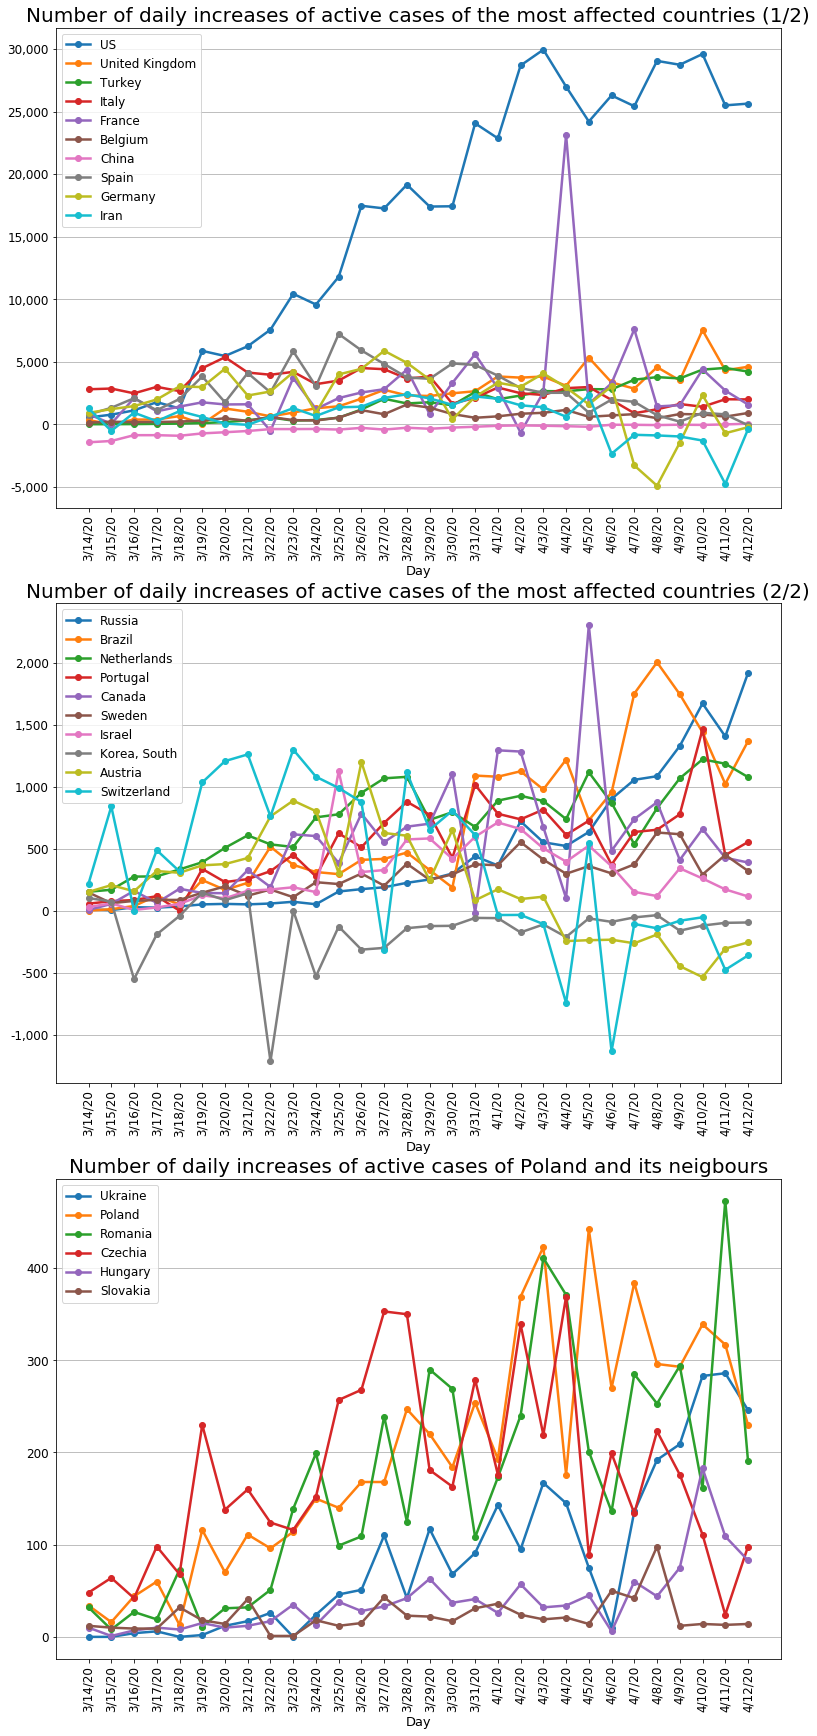

In [28]:
# make a visualisation of daily increases of active cases
# for 20 most affected countries and Poland and its neigbours
nr_countries = [10, 10, 6]
nr_window_days = 30
countries = [conf_df.index[:nr_countries[0]],  
            conf_df.index[nr_countries[0]: nr_countries[1]+10],
            ['Poland', 'Czechia', 'Slovakia', 'Hungary', 'Romania', 'Ukraine']]

titles = ['Number of daily increases of active cases of the most affected countries (1/2)',
         'Number of daily increases of active cases of the most affected countries (2/2)',
         'Number of daily increases of active cases of Poland and its neigbours']

draw_countries_plot(len(countries), nr_countries, nr_window_days,
                    diff_active_df, countries, titles, '7_daily_increases_active.png')

In [29]:
conf_per_df.loc[countries[0]].sort_values(conf_per_df.columns[-1], ascending=False)

1/22/20   1/23/20   1/24/20   1/25/20   1/26/20   1/27/20  \
Country                                                                      
Spain           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Belgium         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Italy           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
France          0.000000  0.000000  0.000299  0.000448  0.000448  0.000448   
US              0.000031  0.000031  0.000061  0.000061  0.000153  0.000153   
Germany         0.000000  0.000000  0.000000  0.000000  0.000000  0.000121   
United Kingdom  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Iran            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Turkey          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
China           0.003935  0.004617  0.006606  0.010095  0.014899  0.020657   

                 1/28/20   1/29/20   1/30/20   1/31/20  ...     4/3/20  \
Country                                                 ...              
Spain           0.000000  0.000000  0.000000  0.000000  ...  25.511437   
Belgium         0.000000  0.000000  0.000000  0.000000  ...  14.682105   
Italy           0.000000  0.000000  0.000000  0.000331  ...  19.828637   
France          0.000597  0.000746  0.000746  0.000746  ...   9.733495   
US              0.000153  0.000153  0.000153  0.000214  ...   8.423393   
Germany         0.000482  0.000482  0.000482  0.000603  ...  10.992558   
United Kingdom  0.000000  0.000000  0.000000  0.000301  ...   5.818858   
Iran            0.000000  0.000000  0.000000  0.000000  ...   6.501568   
Turkey          0.000000  0.000000  0.000000  0.000000  ...   2.541432   
China           0.039555  0.043706  0.058454  0.070380  ...   0.592441   

                   4/4/20     4/5/20     4/6/20     4/7/20     4/8/20  \
Country                                                                 
Spain           27.002970  28.175393  29.251720  30.378984  31.722626   
Belgium         16.136307  17.239435  18.222620  19.430807  20.489284   
Italy           20.623755  21.337955  21.933508  22.436393  23.071163   
France          13.561985  13.998635  14.773410  16.430740  17.012045   
US               9.440212  10.302737  11.207320  12.110710  13.114141   
Germany         11.587412  12.073497  12.465524  12.982720  13.661985   
United Kingdom   6.388576   7.284815   7.862805   8.414777   9.245741   
Iran             6.814525   7.118070   7.396064   7.651442   7.895573   
Turkey           2.907444   3.288276   3.670688   4.143478   4.643602   
China            0.592671   0.593094   0.593546   0.593927   0.594580   

                   4/9/20    4/10/20    4/11/20    4/12/20  
Country                                                     
Spain           32.793173  33.874208  34.891678  35.705825  
Belgium         21.872572  23.346911  24.529709  25.955895  
Italy           23.766830  24.420630  25.197380  25.874513  
France          17.731883  18.799251  19.515208  19.954545  
US              14.104002  15.176786  16.089499  16.973358  
Germany         14.251050  14.732191  15.062237  15.417485  
United Kingdom   9.907204  11.220655  12.013117  12.815054  
Iran             8.095328   8.336403   8.560974   8.763541  
Turkey           5.136315   5.712969   6.337120   6.918876  
China            0.595112   0.595528   0.596052   0.596914  

[10 rows x 82 columns]

In [30]:
countries1 = [conf_per_df.loc[countries[0]].sort_values(conf_per_df.columns[-1], ascending=False).index,
            conf_per_df.loc[countries[1]].sort_values(conf_per_df.columns[-1], ascending=False).index,
            conf_per_df.loc[countries[2]].sort_values(conf_per_df.columns[-1], ascending=False).index]
countries1

[Index(['Spain', 'Belgium', 'Italy', 'France', 'US', 'Germany',
        'United Kingdom', 'Iran', 'Turkey', 'China'],
       dtype='object', name='Country'),
 Index(['Switzerland', 'Portugal', 'Austria', 'Netherlands', 'Israel', 'Sweden',
        'Canada', 'Korea, South', 'Russia', 'Brazil'],
       dtype='object', name='Country'),
 Index(['Czechia', 'Romania', 'Poland', 'Hungary', 'Slovakia', 'Ukraine'], dtype='object')]

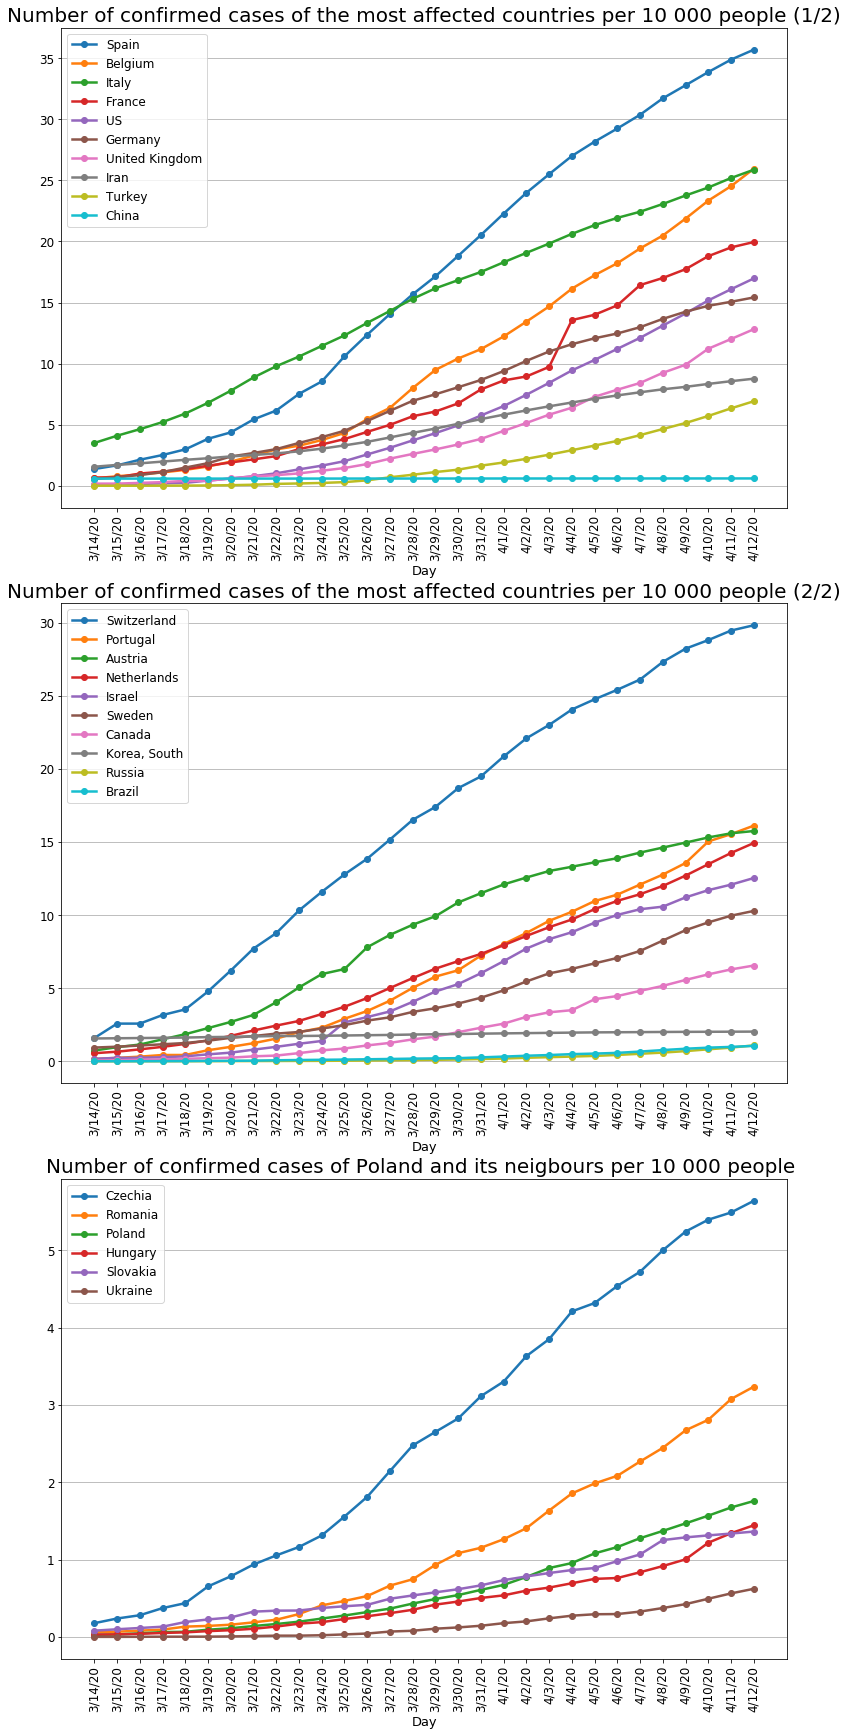

In [31]:
# make a visualisation of confirmed cases per capita
nr_countries = [10, 10, 6]
nr_window_days = 30
countries = [conf_df.index[:nr_countries[0]],
            conf_df.index[nr_countries[0]: nr_countries[1]+10],
            ['Poland', 'Czechia', 'Slovakia', 'Hungary', 'Romania', 'Ukraine']]

titles = ['Number of confirmed cases of the most affected countries per 10 000 people (1/2)',
         'Number of confirmed cases of the most affected countries per 10 000 people (2/2)',
         'Number of confirmed cases of Poland and its neigbours per 10 000 people ']

draw_countries_plot(len(countries), nr_countries, nr_window_days,
                    conf_per_df, countries, titles, '8_conf_per_people.png')

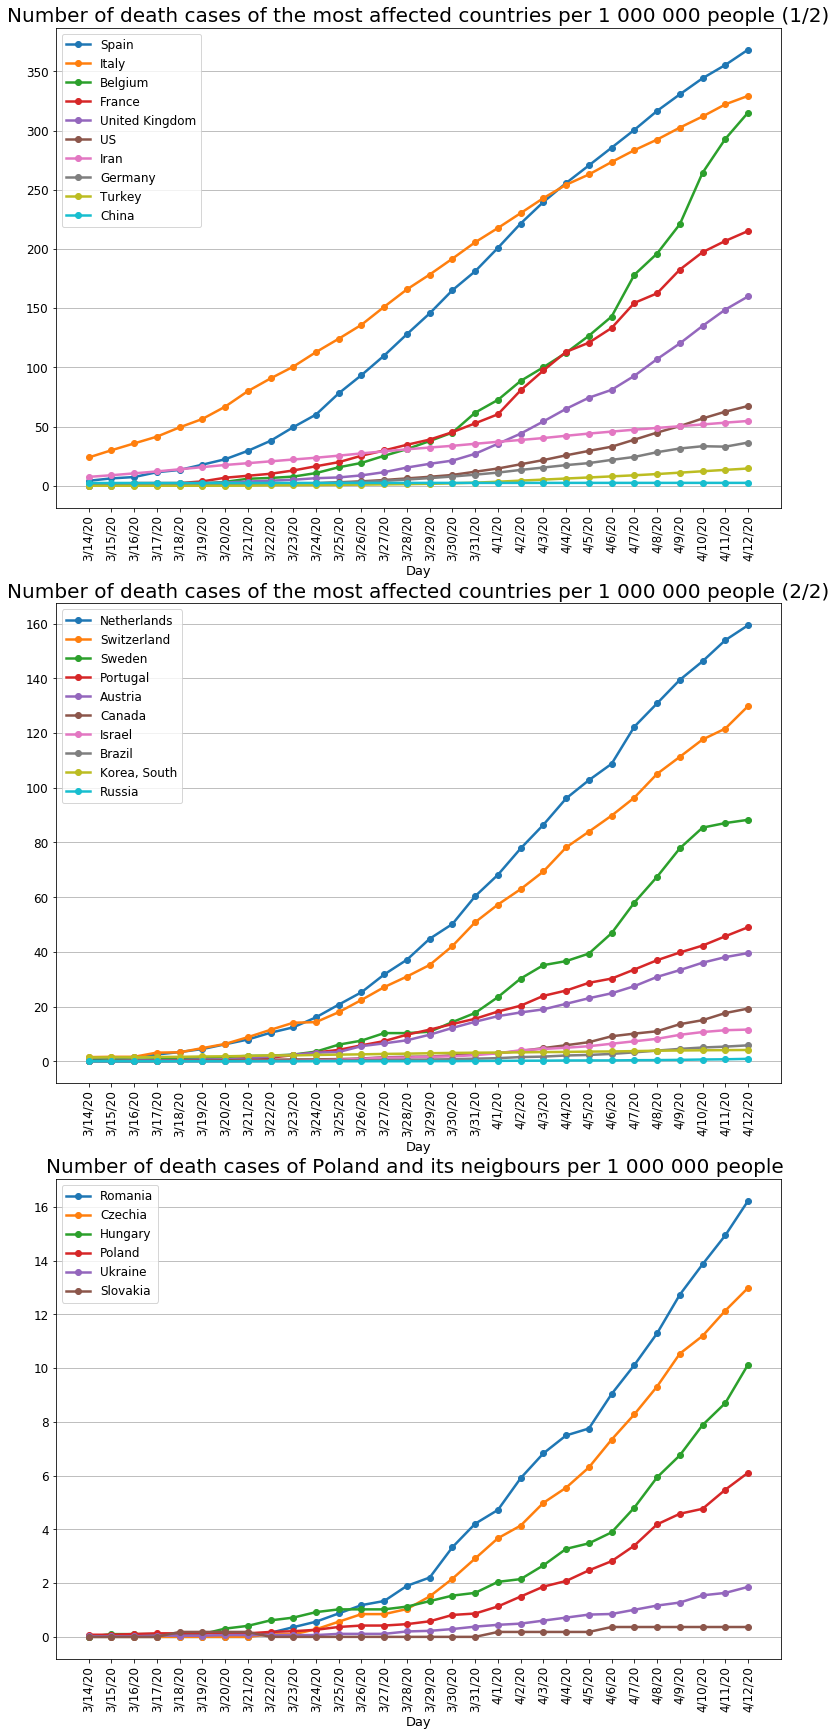

In [32]:
# make a visualisation of deaths per capita
nr_countries = [10, 10, 6]
nr_window_days = 30
countries = [conf_df.index[:nr_countries[0]],  
            conf_df.index[nr_countries[0]:nr_countries[1]+10],
            ['Poland', 'Czechia', 'Slovakia', 'Hungary', 'Romania', 'Ukraine']]

titles = ['Number of death cases of the most affected countries per 1 000 000 people (1/2)',
         'Number of death cases of the most affected countries per 1 000 000 people (2/2)',
         'Number of death cases of Poland and its neigbours per 1 000 000 people ']

draw_countries_plot(len(countries), nr_countries, nr_window_days,
                    death_per_df, countries, titles, '9_death_per.png')

The median and mean of death ratio from the last day are respectively: 2.4 and 3.9.


4/6/20  4/7/20  4/8/20  4/9/20  4/10/20  4/11/20  4/12/20
Country                                                                  
Italy             12.5    12.6    12.7    12.7     12.8     12.8     12.7
United Kingdom    10.3    11.0    11.6    12.1     12.0     12.4     12.5
Belgium            7.8     9.2     9.6    10.1     11.3     11.9     12.1
France             9.0     9.4     9.6    10.3     10.5     10.6     10.8
Netherlands        9.9    10.7    10.9    11.0     10.8     10.8     10.7
Spain              9.8     9.9    10.0    10.1     10.2     10.2     10.3
Iran               6.2     6.2     6.2     6.2      6.2      6.2      6.2
Brazil             4.6     4.9     5.1     5.3      5.4      5.4      5.5
Switzerland        3.5     3.7     3.8     3.9      4.1      4.1      4.4
US                 2.9     3.2     3.4     3.6      3.7      3.9      4.0
China              4.0     4.0     4.0     4.0      4.0      4.0      4.0
Portugal           2.7     2.8     2.9     2.9      2.8      2.9      3.0
Canada             2.0     2.1     2.1     2.4      2.5      2.8      2.9
Germany            1.8     1.9     2.1     2.2      2.3      2.2      2.4
Turkey             2.1     2.1     2.1     2.1      2.1      2.1      2.1

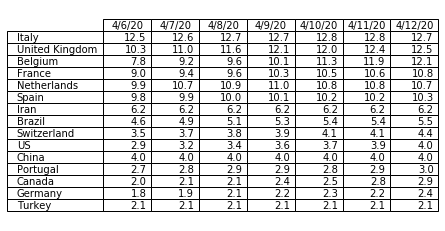

In [33]:
# a table showing a death ratio by countries
death_ratio_df = (death_df / conf_df * 100).round(1)

# count the median and mean
last_day_median = round((death_ratio_df.median(axis=0)[-1]), 1)
last_day_mean = round((death_ratio_df.mean(axis=0)[-1]), 1)

print('The median and mean of death ratio from the last day \
are respectively: \033[1m{median}\033[0m \
and \033[1m{mean}\033[0m.'.format(median=last_day_median,
                                        mean=last_day_mean))

# show a table with the death ratio of the most affected countries
most_affected_countries = conf_df.index[:15]
show_death_ratio_df = death_ratio_df.loc[most_affected_countries].iloc[:15, -7:].sort_values(by=conf_df.columns[-1], ascending=False)

save_df_as_png(show_death_ratio_df, '10t_death_ratio.png')
show_death_ratio_df

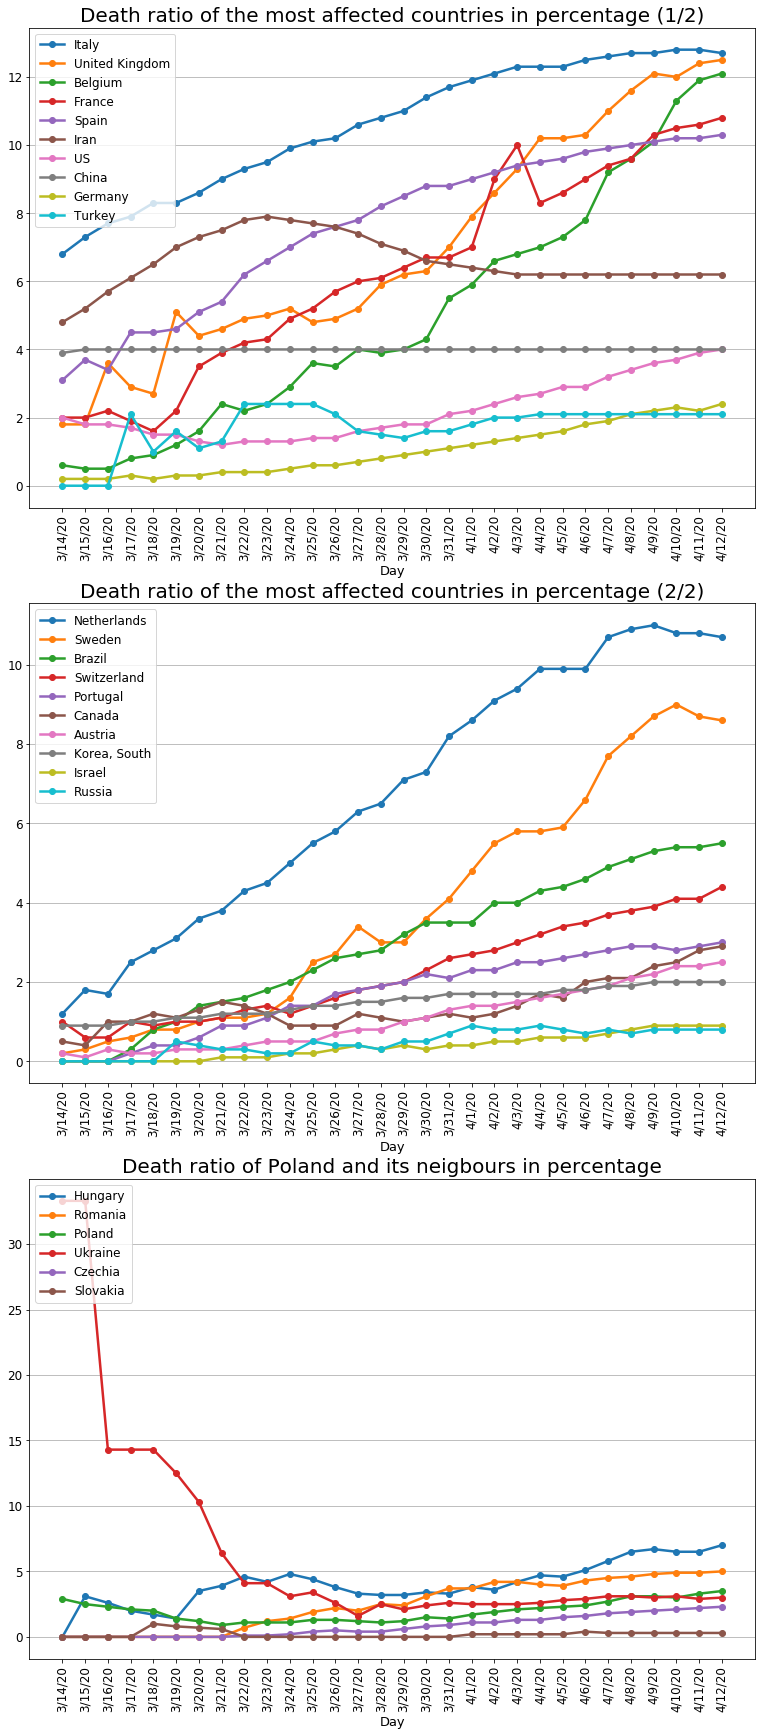

In [34]:
# make a visualisation of the death ratio of 20 most affected countries
# and Poland and its neighbours
nr_countries = [10, 10, 6]
nr_window_days = 30
countries = [conf_df.index[np.arange(nr_countries[0])],  
            conf_df.index[np.arange(nr_countries[0], nr_countries[1]+10)],
            ['Poland', 'Czechia', 'Slovakia', 'Hungary', 'Romania', 'Ukraine']]

titles = ['Death ratio of the most affected countries in percentage (1/2)',
         'Death ratio of the most affected countries in percentage (2/2)',
         'Death ratio of Poland and its neigbours in percentage']

draw_countries_plot(len(countries), nr_countries, nr_window_days,
                    death_ratio_df, countries, titles, '10_death_ratio.png')